In [7]:
import os
import logging
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from glob import glob
from astropy import units as u
from lenstools import ConvergenceMap

from src.utils.ConfigData import ConfigData, ConfigAnalysis
from src.flatsky.fibonacci_patch import patch_handler

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [9]:
nside = 8192
patch_size = 10
xsize=1024
reso = patch_size*60/xsize
nbin= 15
lmin, lmax = 300, 3000

bins = np.linspace(-4, 4, nbin+1, endpoint=True)
l_edges = np.linspace(lmin, lmax, nbin+1, endpoint=True)

In [10]:
config_file = os.path.join("/lustre/work/akira.tokiwa/Projects/LensingSSC/configs", 'config_data.json')
config_data = ConfigData.from_json(config_file)

config_analysis_file = os.path.join("/lustre/work/akira.tokiwa/Projects/LensingSSC/configs", 'config_analysis.json')
config_analysis = ConfigAnalysis.from_json(config_analysis_file)

In [11]:
dir_results_tiled = os.path.join(config_analysis.resultsdir, 'tiled')
dir_results_bigbox = os.path.join(config_analysis.resultsdir, 'bigbox')

# load catalog

In [12]:
from astropy.cosmology import FlatLambdaCDM
from src.utils.ConfigData import ConfigData, CatalogHandler

def set_cosmology(h=0.6774, om=0.309):
    """
    Set the cosmological parameters for the simulation
    if not using the default Planck15 cosmology.
    """
    global HUBBLE_CONSTANT, OMEGA_MATTER, cosmo
    HUBBLE_CONSTANT = h
    OMEGA_MATTER = om
    cosmo = FlatLambdaCDM(H0=HUBBLE_CONSTANT * 100, Om0=OMEGA_MATTER)

set_cosmology()

In [13]:
cath = CatalogHandler(config_data.tileddir, config_data.source, config_data.dataset)

/home/akira.tokiwa/.conda/envs/lssc/lib/python3.8/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)
2024-07-31 07:52:34,886 - INFO - Extra arguments to FileType: () {'dataset': 'HEALPIX/'}


In [14]:
boxsize, M_cdm, nc = cath.cat.attrs['BoxSize'][0], cath.cat.attrs['MassTable'][1], cath.cat.attrs['NC'][0]
print(f"Boxsize: {boxsize}, M_cdm: {M_cdm}, nc: {nc}")

Boxsize: 625.0, M_cdm: 1.9487254007799495, nc: 1024


In [15]:
sizes = cath.cat.attrs['aemitIndex.size']
print(len(sizes))

102


# load Mass sheet

In [16]:
mass_files_tiled = sorted(glob(f"{config_data.tileddir}/mass_sheets/*.npz"))
mass_files_bigbox = sorted(glob(f"{config_data.bigboxdir}/mass_sheets/*.npz"))

sample_mass_tiled = np.load(mass_files_tiled[10])
sample_mass_bigbox = np.load(mass_files_bigbox[10])

In [17]:
delta_tiled = sample_mass_tiled["delta"]
delta_bigbox = sample_mass_bigbox["delta"]

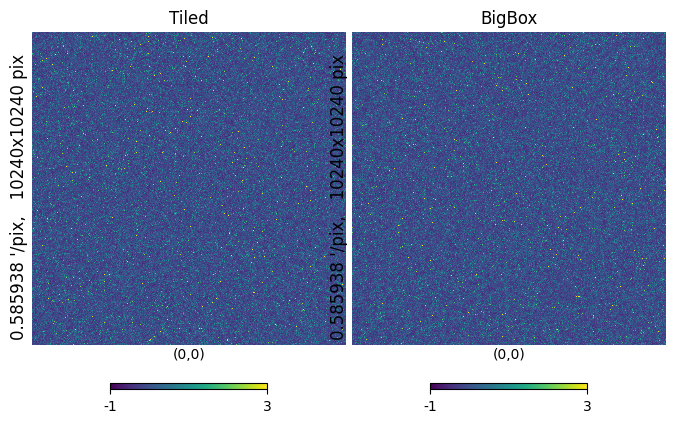

In [27]:
hp.gnomview(delta_tiled, rot=[0, 0], reso=reso, xsize=xsize*10, title="Tiled", sub=(1, 2, 1), min=-1, max=3)
hp.gnomview(delta_bigbox, rot=[0, 0], reso=reso, xsize=xsize*10, title="BigBox", sub=(1, 2, 2), min=-1, max=3)
plt.show()

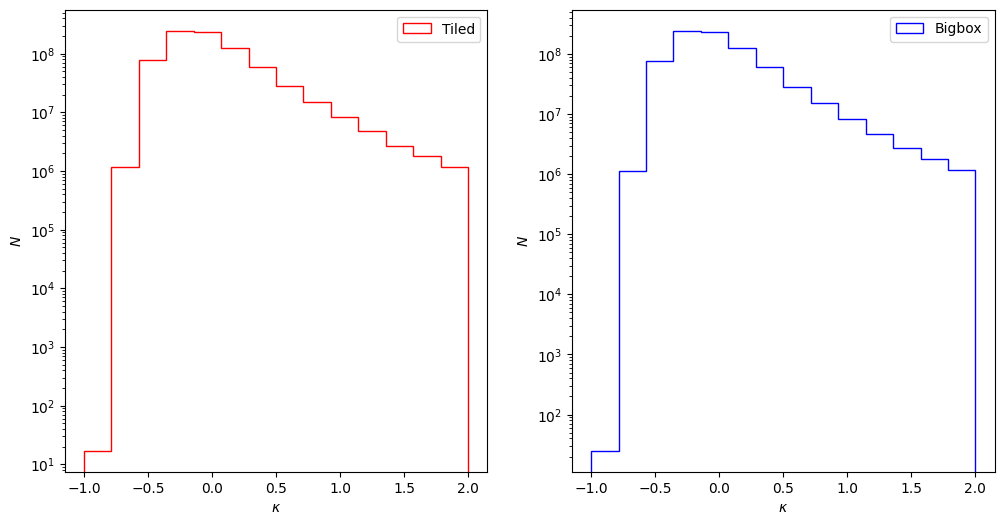

In [19]:
# plot the histogram of the convergence map
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(delta_tiled.flatten(), bins=np.linspace(-1, 2, 15), histtype='step', color='r', label='Tiled')
ax[1].hist(delta_bigbox.flatten(), bins=np.linspace(-1, 2, 15), histtype='step', color='b', label='Bigbox')

ax[0].set_xlabel(r"$\kappa$")
ax[0].set_ylabel(r"$N$")
ax[0].set_yscale('log')
ax[0].legend()

ax[1].set_xlabel(r"$\kappa$")
ax[1].set_ylabel(r"$N$")
ax[1].set_yscale('log')
ax[1].legend()

plt.show()

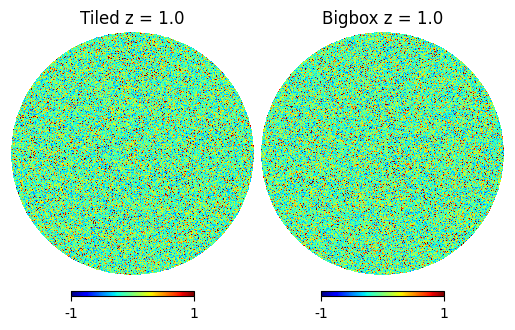

In [12]:
fig = plt.figure(figsize=(5, 3))
hp.orthview(delta_tiled, fig=1, title='Tiled z = 1.0', sub=(1, 2, 1), cmap="jet", min=-1, max=1, half_sky=True)
hp.orthview(delta_bigbox, fig=1, title='Bigbox z = 1.0', sub=(1, 2, 2),cmap="jet", min=-1, max=1, half_sky=True)

# load data

In [5]:
fnames_tiled = sorted(glob(os.path.join(dir_results_tiled, "data", f"kappa_zs*.fits")))
fnames_bigbox = sorted(glob(os.path.join(dir_results_bigbox, "data", f"kappa_zs*.fits")))

sample_tiled = hp.read_map(fnames_tiled[1])
sample_bigbox = hp.read_map(fnames_bigbox[1])

sigma_tiled = np.std(sample_tiled)
sigma_bigbox = np.std(sample_bigbox)

snr_tiled = sample_tiled/ sigma_tiled
snr_bigbox = sample_bigbox/ sigma_bigbox

2024-07-19 08:35:14,299 - INFO - NSIDE = 8192
2024-07-19 08:35:14,300 - INFO - ORDERING = RING in fits file
2024-07-19 08:35:14,300 - INFO - INDXSCHM = IMPLICIT
2024-07-19 08:35:30,198 - INFO - NSIDE = 8192
2024-07-19 08:35:30,199 - INFO - ORDERING = RING in fits file
2024-07-19 08:35:30,200 - INFO - INDXSCHM = IMPLICIT


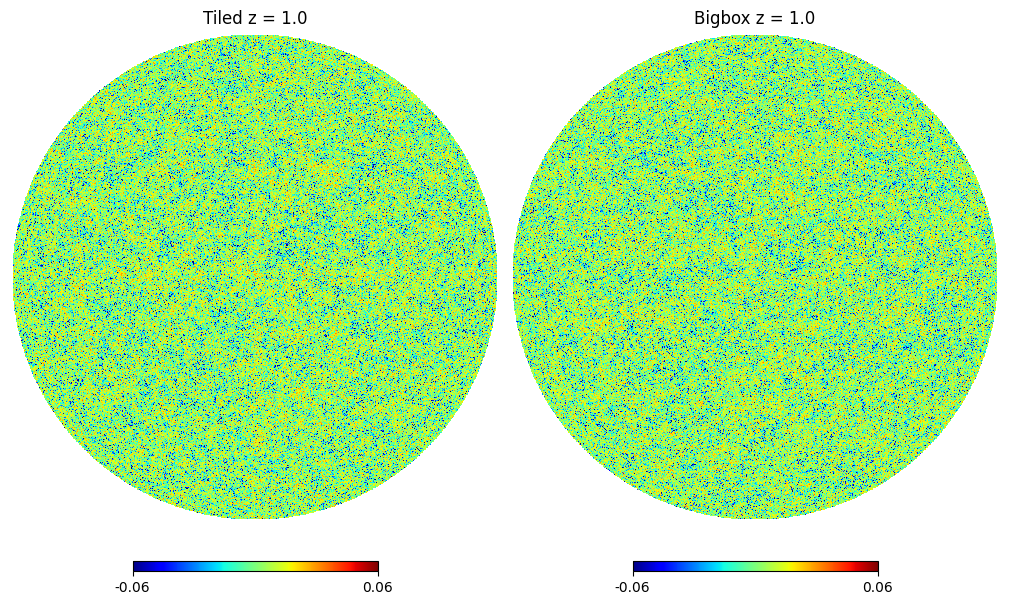

In [6]:
fig = plt.figure(figsize=(10, 8))
hp.orthview(sample_tiled, fig=1, title='Tiled z = 1.0', sub=(1, 2, 1), nest=True, cmap="jet", min=-0.06, max=0.06, half_sky=True)
hp.orthview(sample_bigbox, fig=1, title='Bigbox z = 1.0', sub=(1, 2, 2), nest=True, cmap="jet", min=-0.06, max=0.06, half_sky=True)

## sample PDF

In [7]:
count_tiled, _ = np.histogram(snr_tiled, density=True, bins=bins)
count_bigbox, _ = np.histogram(snr_bigbox, density=True, bins=bins)

fig = plt.figure(figsize=(7, 5))
plt.plot(np.linspace(-4, 4, 15), count_tiled, label='Tiled')
plt.plot(np.linspace(-4, 4, 15), count_bigbox, label='Bigbox')

plt.xlabel('SNR')
plt.ylabel('Probability')
plt.yscale('log')
plt.legend()
plt.show()

KeyboardInterrupt: 

# Patch Sky

In [10]:
ph_tiled = patch_handler(sample_tiled, patch_size, xsize, N=273, nest=True)
ph_bigbox = patch_handler(sample_bigbox, patch_size, xsize, N=273, nest=True)

ph_tiled.perform_patch()
ph_bigbox.perform_patch()

In [5]:
from scipy.spatial import cKDTree

def fibonacci_grid_on_sphere(N):
    """
    Generate an array of points on a Fibonacci grid on a sphere.

    Parameters:
    N (int): Number of points to distribute on the sphere.

    Returns:
    np.ndarray: Array of shape (N, 2) where each row contains (theta, phi) coordinates of a point.
    """
    points = np.zeros((N, 2))
    
    phi = (np.sqrt(5) + 1) / 2  # Golden ratio
    golden_angle = 2 * np.pi / phi
    
    for i in range(N):
        theta = np.arccos(1 - 2 * (i + 0.5) / N)
        phi = (golden_angle * i) % (2 * np.pi)
        points[i] = [theta, phi]
    
    return points

def spherical_distance(theta1, phi1, theta2, phi2):
    """
    Calculate the great-circle distance between two points on a sphere given their spherical coordinates.
    """
    delta_phi = phi2 - phi1
    return np.arccos(np.sin(theta1) * np.sin(theta2) + np.cos(theta1) * np.cos(theta2) * np.cos(delta_phi))

def find_optimal_N(min_distance, initial_N=400):
    N = initial_N
    while True:
        points_spherical = fibonacci_grid_on_sphere(N)
        
        # Convert to Cartesian coordinates for KDTree (not for distance calculations)
        points_cartesian = np.array([
            [np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)] 
            for theta, phi in points_spherical
        ])
        
        # Create a KDTree for finding nearest neighbors
        tree = cKDTree(points_cartesian)
        
        # Find the indices of the nearest neighbors
        _, indices = tree.query(points_cartesian, k=2)
        
        # Calculate spherical distances
        nearest_distances = [
            spherical_distance(points_spherical[i][0], points_spherical[i][1], 
                               points_spherical[indices[i][1]][0], points_spherical[indices[i][1]][1])
            for i in range(N)
        ]
        
        min_distance_found = np.min(nearest_distances)
        
        if min_distance_found > min_distance:
            break
        
        N -= 2  # Increment N and try again
    
    return N, points_spherical, nearest_distances

In [6]:
def vertices_from_center(center, patch_size):
    """
    Generate the vertices of a patch centered at a given point on the sphere.
    
    Parameters:
    center (np.ndarray): Array of shape (2,) containing the (theta, phi) coordinates of the center of the patch.
    patch_size (float): Size of the patch in degrees.
    
    Returns:
    np.ndarray: Array of shape (4, 2) containing the (theta, phi) coordinates of the vertices of the patch.
    """
    theta, phi = center
    half_size = np.radians(patch_size) / np.sqrt(2)
    
    vertices = np.array([
        [theta, phi + half_size * np.sin(theta)],
        [theta + half_size, phi],
        [theta, phi - half_size  * np.sin(theta)],
        [theta - half_size, phi]
    ])
    
    return vertices

In [7]:
import math

def M(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

def spherical_to_cartesian(theta, phi, r=1):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

def cartesian_to_spherical(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / r)
    phi = np.arctan2(y, x)
    return r, theta, phi

def rotation_matrix(theta, phi):
    """
    Generate a rotation matrix for rotating a point on the sphere by theta and phi.
    """
    R_phi = M([0, 0, 1], phi)
    R_theta = M(np.array([np.sin(phi), -np.cos(phi), 0]), np.pi/2 - theta)
    return np.dot(R_theta, R_phi)

def rotate_point(point, theta, phi):
    """
    Rotate a point on the sphere by theta and phi.
    """
    x, y, z = spherical_to_cartesian(*point)
    x_rot, y_rot, z_rot = np.dot(rotation_matrix(theta, phi), np.array([x, y, z]))
    return cartesian_to_spherical(x_rot, y_rot, z_rot)[1:]

def rotated_vertices(center, patch_size):
    """
    Generate the vertices of a patch centered at a given point on the sphere, rotated by theta and phi.
    """
    theta, phi = center
    vertices = vertices_from_center([np.pi/2, 0], patch_size)
    rotated_vertices = np.array([rotate_point(vertex, theta, phi) for vertex in vertices])
    return rotated_vertices

In [8]:
radius = np.radians(patch_size)* np.sqrt(2)

def optimal_N(patch_size, N=280):
    flag = True
    radius = np.radians(patch_size) * np.sqrt(2)
    while flag:
        print("testing N = ", N)
        points = fibonacci_grid_on_sphere(N)
        counts = np.zeros(hp.nside2npix(nside))
        for center in points[(points[:, 0] < np.pi - radius) & (points[:, 0] > radius)]:
            vertices = rotated_vertices(center, patch_size)
            vecs = hp.ang2vec(vertices[:, 0], vertices[:, 1])
            ipix = hp.query_polygon(nside=nside, vertices=vecs, nest=True)
            counts[ipix] += 1
            if np.any(counts[ipix] > 1):
                N -= 10
                break
        if np.all(counts[ipix] <= 1):
            flag = False
    return N


N = optimal_N(patch_size)

testing N =  280
testing N =  270
testing N =  260
testing N =  250
testing N =  240
testing N =  230
testing N =  220
testing N =  210
testing N =  200
testing N =  190
testing N =  180
testing N =  170
testing N =  160
testing N =  150
testing N =  140
testing N =  130
testing N =  120
testing N =  110
testing N =  100
testing N =  90
testing N =  80
testing N =  70
testing N =  60
testing N =  50
testing N =  40
testing N =  30


In [20]:
points = fibonacci_grid_on_sphere(N=273)
radius = np.radians(patch_size)* np.sqrt(2)

tmp = np.zeros(hp.nside2npix(nside))

pixels = []
for center in points[(points[:, 0] < np.pi - radius) & (points[:, 0] > radius)]:
    vertices = rotated_vertices(center, patch_size)
    vecs = hp.ang2vec(vertices[:, 0], vertices[:, 1])

    ipix = hp.query_polygon(nside=nside, vertices=vecs, nest=True)
    tmp[ipix] += 1
    pixels.append(len(ipix))

ipix_pole = hp.query_disc(nside=nside, vec=hp.ang2vec(0, 0), radius=radius/2, nest=True)
tmp[ipix_pole] -= 1

ipix_pole = hp.query_disc(nside=nside, vec=hp.ang2vec(np.pi, 0), radius=radius/2, nest=True)
tmp[ipix_pole] -= 1

print(len(points))

273


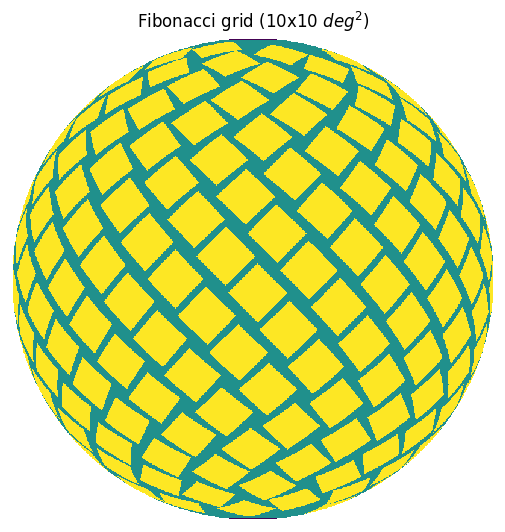

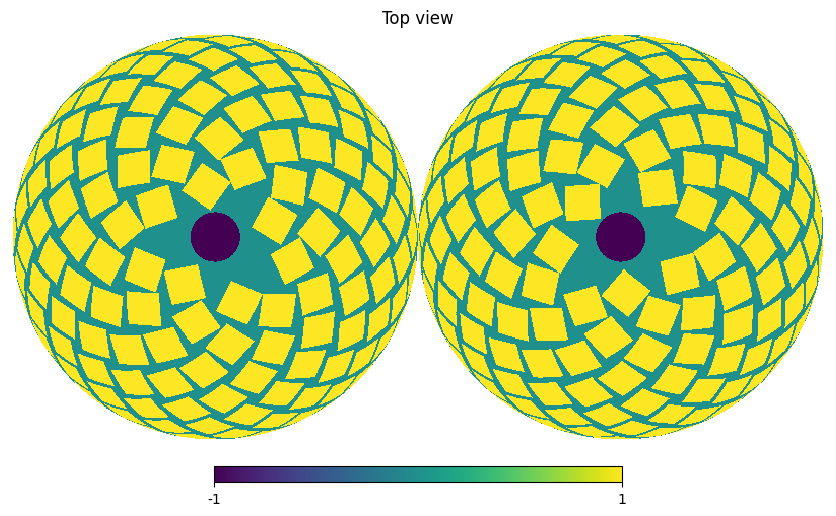

In [25]:
hp.orthview(tmp, title=r'Fibonacci grid (10x10 $deg^2$)', nest=True, half_sky=True, cbar=False)
hp.orthview(tmp, title='Top view', nest=True, rot=(0, 90, 0))

In [49]:
sample_patch_tiled = hp.gnomview(sample_tiled, rot=center, xsize=xsize, reso=patch_size*60/xsize, nest=True, title='Tiled', return_projected_map=True, no_plot=True)
sample_patch_bigbox = hp.gnomview(sample_bigbox, rot=center, xsize=xsize, reso=patch_size*60/xsize, nest=True, title='Bigbox', return_projected_map=True, no_plot=True)

sample_patch_smoothed_tiled = hp.gnomview(sample_smoothed_tiled, rot=center, xsize=xsize, reso=patch_size*60/xsize, title='Tiled smoothed', return_projected_map=True, no_plot=True)
sample_patch_smoothed_bigbox = hp.gnomview(sample_smoothed_bigbox, rot=center, xsize=xsize, reso=patch_size*60/xsize, title='Bigbox smoothed', return_projected_map=True, no_plot=True)

sample_patch_noisy_tiled = hp.gnomview(sample_noisy_tiled, rot=center, xsize=xsize, reso=patch_size*60/xsize, title='Tiled noisy', return_projected_map=True, no_plot=True)
sample_patch_noisy_bigbox = hp.gnomview(sample_noisy_bigbox, rot=center, xsize=xsize, reso=patch_size*60/xsize, title='Bigbox noisy', return_projected_map=True, no_plot=True)

In [50]:
conv_tiled = ConvergenceMap(sample_patch_tiled, angle=patch_size * u.deg)
conv_bigbox = ConvergenceMap(sample_patch_bigbox, angle=patch_size * u.deg)

conv_smoothed_tiled = ConvergenceMap(sample_patch_smoothed_tiled, angle=patch_size * u.deg)
conv_smoothed_bigbox = ConvergenceMap(sample_patch_smoothed_bigbox, angle=patch_size * u.deg)

conv_noisy_tiled = ConvergenceMap(sample_patch_noisy_tiled, angle=patch_size * u.deg)
conv_noisy_bigbox = ConvergenceMap(sample_patch_noisy_bigbox, angle=patch_size * u.deg)

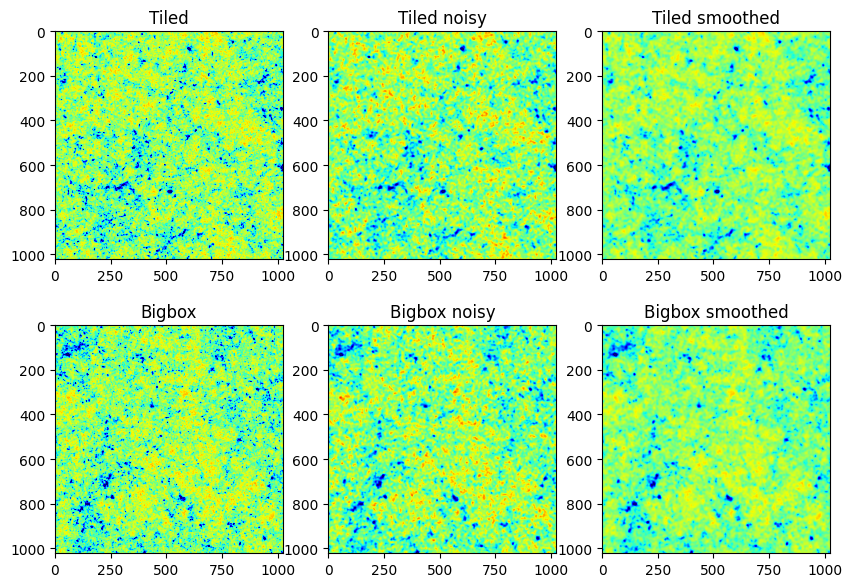

In [51]:
fig, ax = plt.subplots(2, 3, figsize=(10, 7))
ax[0, 0].imshow(conv_tiled.data, cmap='jet', vmin=-0.06, vmax=0.06)
ax[0, 0].set_title('Tiled')

ax[0, 1].imshow(conv_noisy_tiled.data, cmap='jet', vmin=-0.06, vmax=0.06)
ax[0, 1].set_title('Tiled noisy')

ax[0, 2].imshow(conv_smoothed_tiled.data, cmap='jet', vmin=-0.06, vmax=0.06)
ax[0, 2].set_title('Tiled smoothed')

ax[1, 0].imshow(conv_bigbox.data, cmap='jet', vmin=-0.06, vmax=0.06)
ax[1, 0].set_title('Bigbox')

ax[1, 1].imshow(conv_noisy_bigbox.data, cmap='jet', vmin=-0.06, vmax=0.06)
ax[1, 1].set_title('Bigbox noisy')

ax[1, 2].imshow(conv_smoothed_bigbox.data, cmap='jet', vmin=-0.06, vmax=0.06)
ax[1, 2].set_title('Bigbox smoothed')

plt.show()

## Peaks, PDF

In [52]:
def exclude_edges(heights, positions, patch_size_deg, xsize, return_index=True):
    tmp_positions = positions.value * xsize / patch_size_deg
    mask = (tmp_positions[:, 0] > 0) & (tmp_positions[:, 0] < xsize-1) & (tmp_positions[:, 1] > 0) & (tmp_positions[:, 1] < xsize-1)
    if return_index:
        return heights[mask], tmp_positions[mask].astype(int)
    else:
        return heights[mask], positions[mask]

In [53]:
height_tiled, positions_tiled = conv_smoothed_tiled.locatePeaks(bins * sigma_smoothed_tiled)
height_tiled, positions_tiled = exclude_edges(height_tiled, positions_tiled, patch_size, xsize)
height_bigbox, positions_bigbox = conv_smoothed_bigbox.locatePeaks(bins * sigma_smoothed_bigbox)
height_bigbox, positions_bigbox = exclude_edges(height_bigbox, positions_bigbox, patch_size, xsize)

height_noisy_tiled, positions_noisy_tiled = conv_noisy_tiled.locatePeaks(bins * sigma_noisy_tiled)
height_noisy_tiled, positions_noisy_tiled = exclude_edges(height_noisy_tiled, positions_noisy_tiled, patch_size, xsize)
height_noisy_bigbox, positions_noisy_bigbox = conv_noisy_bigbox.locatePeaks(bins * sigma_noisy_bigbox)
height_noisy_bigbox, positions_noisy_bigbox = exclude_edges(height_noisy_bigbox, positions_noisy_bigbox, patch_size, xsize)

In [54]:
print(len(positions_tiled), len(positions_bigbox), len(positions_noisy_tiled), len(positions_noisy_bigbox))

2411 2359 3567 3580


In [55]:
nu_tiled, pdf_tiled = conv_smoothed_tiled.pdf(bins * sigma_smoothed_tiled)
nu_bigbox, pdf_bigbox = conv_smoothed_bigbox.pdf(bins * sigma_smoothed_bigbox)

nu_noisy_tiled, pdf_noisy_tiled = conv_noisy_tiled.pdf(bins * sigma_noisy_tiled)
nu_noisy_bigbox, pdf_noisy_bigbox = conv_noisy_bigbox.pdf(bins * sigma_noisy_bigbox)

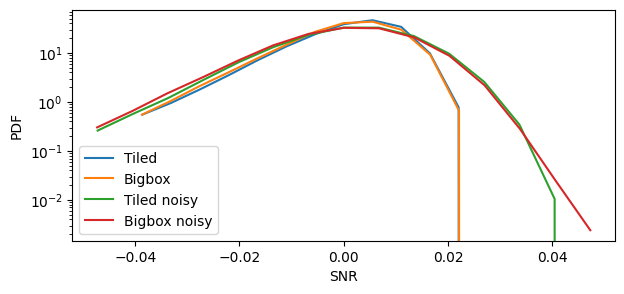

In [56]:
fig = plt.figure(figsize=(7, 3))
plt.plot(nu_tiled, pdf_tiled, label='Tiled')
plt.plot(nu_bigbox, pdf_bigbox, label='Bigbox')
plt.plot(nu_noisy_tiled, pdf_noisy_tiled, label='Tiled noisy')
plt.plot(nu_noisy_bigbox, pdf_noisy_bigbox, label='Bigbox noisy')
plt.xlabel('SNR')
plt.ylabel('PDF')
plt.yscale('log')
plt.legend()

## power spectrum, bispectrum

In [58]:
ell, ps_tiled = conv_tiled.powerSpectrum(l_edges)
ell, ps_bigbox = conv_bigbox.powerSpectrum(l_edges)

ell, ps_smoothed_tiled = conv_smoothed_tiled.powerSpectrum(l_edges)
ell, ps_smoothed_bigbox = conv_smoothed_bigbox.powerSpectrum(l_edges)

ell, ps_noisy_tiled = conv_noisy_tiled.powerSpectrum(l_edges)
ell, ps_noisy_bigbox = conv_noisy_bigbox.powerSpectrum(l_edges)

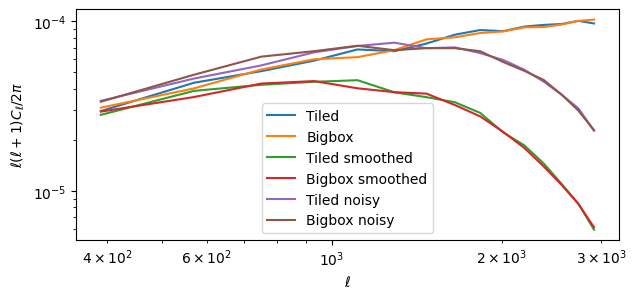

In [60]:
fig = plt.figure(figsize=(7, 3))
plt.plot(ell, ps_tiled * ell * (ell+1) / 2 / np.pi, label='Tiled')
plt.plot(ell, ps_bigbox * ell * (ell+1) / 2 / np.pi, label='Bigbox')
plt.plot(ell, ps_smoothed_tiled * ell * (ell+1) / 2 / np.pi, label='Tiled smoothed')
plt.plot(ell, ps_smoothed_bigbox * ell * (ell+1) / 2 / np.pi, label='Bigbox smoothed')
plt.plot(ell, ps_noisy_tiled * ell * (ell+1) / 2 / np.pi, label='Tiled noisy')
plt.plot(ell, ps_noisy_bigbox * ell * (ell+1) / 2 / np.pi, label='Bigbox noisy')

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_{\ell}/2\pi$')
plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.show()


In [61]:
ell, bseq_tiled = conv_tiled.bispectrum(l_edges, configuration='equilateral')
ell, bseq_bigbox = conv_bigbox.bispectrum(l_edges, configuration='equilateral')

ell, bseq_smoothed_tiled = conv_smoothed_tiled.bispectrum(l_edges, configuration='equilateral')
ell, bseq_smoothed_bigbox = conv_smoothed_bigbox.bispectrum(l_edges, configuration='equilateral')

ell, bseq_noisy_tiled = conv_noisy_tiled.bispectrum(l_edges, configuration='equilateral')
ell, bseq_noisy_bigbox = conv_noisy_bigbox.bispectrum(l_edges, configuration='equilateral')

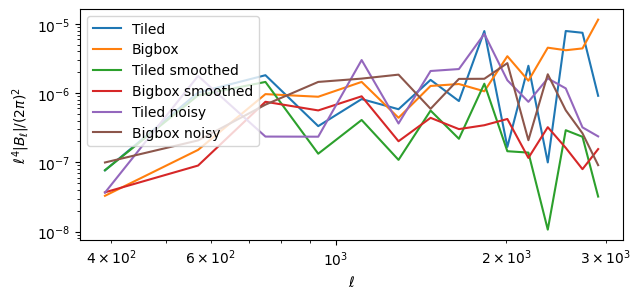

In [63]:
fig = plt.figure(figsize=(7, 3))
plt.plot(ell, np.abs(bseq_tiled) * ell**4 / (2*np.pi)**2, label='Tiled')
plt.plot(ell, np.abs(bseq_bigbox) * ell**4 / (2*np.pi)**2, label='Bigbox')
plt.plot(ell, np.abs(bseq_smoothed_tiled) * ell**4 / (2*np.pi)**2, label='Tiled smoothed')
plt.plot(ell, np.abs(bseq_smoothed_bigbox) * ell**4 / (2*np.pi)**2, label='Bigbox smoothed')
plt.plot(ell, np.abs(bseq_noisy_tiled) * ell**4 / (2*np.pi)**2, label='Tiled noisy')
plt.plot(ell, np.abs(bseq_noisy_bigbox) * ell**4 / (2*np.pi)**2, label='Bigbox noisy')

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell^4|B_{\ell}|/(2\pi)^2$')
plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.show()

In [64]:
ell, bssq_tiled = conv_tiled.bispectrum(l_edges, configuration='folded', ratio=0.1)
ell, bssq_bigbox = conv_bigbox.bispectrum(l_edges, configuration='folded', ratio=0.1)

ell, bssq_smoothed_tiled = conv_smoothed_tiled.bispectrum(l_edges, configuration='folded', ratio=0.1)
ell, bssq_smoothed_bigbox = conv_smoothed_bigbox.bispectrum(l_edges, configuration='folded', ratio=0.1)

ell, bssq_noisy_tiled = conv_noisy_tiled.bispectrum(l_edges, configuration='folded', ratio=0.1)
ell, bssq_noisy_bigbox = conv_noisy_bigbox.bispectrum(l_edges, configuration='folded', ratio=0.1)

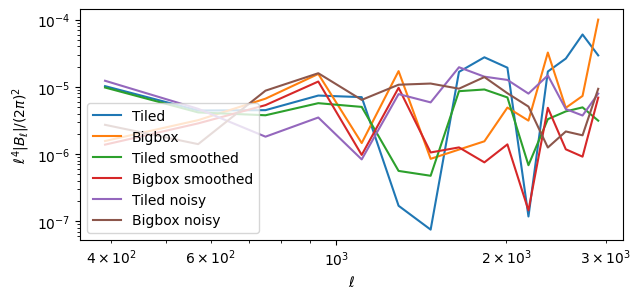

In [65]:
fig = plt.figure(figsize=(7, 3))
plt.plot(ell, np.abs(bssq_tiled) * ell**4 / (2*np.pi)**2, label='Tiled')
plt.plot(ell, np.abs(bssq_bigbox) * ell**4 / (2*np.pi)**2, label='Bigbox')
plt.plot(ell, np.abs(bssq_smoothed_tiled) * ell**4 / (2*np.pi)**2, label='Tiled smoothed')
plt.plot(ell, np.abs(bssq_smoothed_bigbox) * ell**4 / (2*np.pi)**2, label='Bigbox smoothed')
plt.plot(ell, np.abs(bssq_noisy_tiled) * ell**4 / (2*np.pi)**2, label='Tiled noisy')
plt.plot(ell, np.abs(bssq_noisy_bigbox) * ell**4 / (2*np.pi)**2, label='Bigbox noisy')

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell^4|B_{\ell}|/(2\pi)^2$')
plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.show()